# U4 Clustering: K-means algorithm

# Index

1. Partitional clustering
2. Criterion sum of squared errors
3. $K$-means algorithm by Duda and Hart
4. Conventional $K$-means algorithm
5. Lloyd's algorithm
6. Evaluation of clustering

# 1 Partitional clustering

**Partitional clustering:** $\;$ given a dataset $\mathcal{D}$ of $N$ samples and a number of clusters $K,\,$ the partitional clustering consists of optimizing some criterion function $J(\Pi)$ to evaluate the quality of any partition $\Pi$ of the dataset into $K$ clusters
$$\Pi^* = \operatorname*{argopt}_{\Pi} J(\Pi)$$

**Intractability:** $\;$ partitional clustering is in general an intractable problem since the number of partitions to explore grows exponentially with $N$ and $K$ (see [Stirling numbers of the second kind](https://en.wikipedia.org/wiki/Stirling_numbers_of_the_second_kind))

**Usual approximation:** $\;$ we use approximate algorithms to optimize a particular criterion such as the sum of squared errors

# 2 Criterion: sum of squared errors

**Sum of squared errors (SEQ):** $\;$ of a partition $\Pi=\{X_1,\dotsc,X_K\}$
$$J(\Pi) = \sum_{k=1}^K J_k%
\quad\text{with}\quad%
J_k = \sum_{\boldsymbol{x}\in X_k} \lVert{\boldsymbol{x}-\boldsymbol{m}_k}\rVert_2^2
\quad\text{and}\quad%
\boldsymbol{m}_k = \frac{1}{\lvert X_k\rvert}\sum_{\boldsymbol{x}\in X_k} \boldsymbol{x}$$

**Interpretation:**
* Each cluster $k$ is represented by its **centroid** or **mean** $\,\boldsymbol{m}_k$
* If $\boldsymbol{x}$ belongs to cluster $k$, $\boldsymbol{x}-\boldsymbol{m}_k$ is the **error vector** obtained by representing $\boldsymbol{x}$ with $ \boldsymbol{m}_k$
* The error associated with $\boldsymbol{x}$ is measured by the Euclidean norm of its error vector, $\lVert{\boldsymbol{x}-\boldsymbol{m}_k}\rVert_2$
* We call the sum of the squared errors of the cluster $k$, $\,J_k,\,$ the **distortion** of cluster $k$
* The SEQ criterion is the sum of the distortions of all clusters and is obviously a criterion to be minimized
* Ideally, we expect compact hyper-spherical clusters of similar size, around $K$ well-separated averages
* If the natural partition of the data is different from that expected, it is likely that SEQ minimization will not find it

**Example:** $\;$ calculation of the SEQ for $\Pi=\{X_1=\{(1, 7)^t, (4, 2)^t, (4,6)^t\}, X_2=\{(8, 2)^t, (8, 6)^t\}\}$
$$\begin{align*}
\boldsymbol{m}_1&=(3,5)^t&&J_1=8+10+2=20\\
\boldsymbol{m}_2&=(8,4)^t&&J_2=4+4=8
\end{align*}$$
$$J=J_1+J_2=28$$

In [1]:
import numpy as np; np.set_printoptions(precision=2)
def SEQ(X, y): # labels from 0 to K-1 for simplicity
    N, D = X.shape; K = np.max(y)+1; J = 0.0; m = np.zeros((K, D)); S = np.zeros(K).astype(int)
    for k in range(K):
        Xk = np.squeeze(X[np.where(y==k),:]); S[k] = Xk.shape[0]; 
        m[k] = Xk.mean(axis=0); J += np.square(Xk - m[k]).sum()
    return J, m, S
X = np.array([[1, 7], [4, 2], [4, 6], [8, 2], [8, 6]]); y = np.array([0, 0, 0, 1, 1])
J, m, S = SEQ(X, y); print(f'J = {J:.2f} m = {m.reshape(1, -1)} S = {S}')

J = 28.00 m = [[3. 5. 8. 4.]] S = [3 2]


# 3 $K$-means algorithm by Duda and Hart

**SEQ increment when transferring a data sample:** $\;$ if a data $\boldsymbol{x}$ is transferred from cluster $i$ to $j$, the SEQ increment is
$$\Delta J = \frac{\lvert X_j\rvert}{\lvert X_j\rvert + 1}\lVert\boldsymbol{x}-\boldsymbol{m}_j\rVert_2^2-\frac{\lvert X_i\rvert}{\lvert X_i \rvert - 1}\lVert\boldsymbol{x}-\boldsymbol{m}_i \rVert_2^2$$

**DH condition:** $\;$ should be transferred if $\Delta J<0,$ that is, if $J$ is increased less if $\boldsymbol{x}$ is moved into $X_j$ than $J$ is decreased by leaving $\boldsymbol{x}$ in $X_i$
$$\frac{\lvert X_j\rvert}{\lvert X_j\rvert + 1}\lVert\boldsymbol{x}-\boldsymbol{m}_j\rVert_2^2<\frac{\lvert X_i\rvert}{\lvert X_i \rvert - 1}\lVert\boldsymbol{x}-\boldsymbol{m}_i \rVert_2^2$$

**$K$-means algorithm by Duda and Hart:** $\;$ for each data sample, find the transfer of least $\Delta J$ and apply it if it satisfies DH
> **Input:** $\;$ an initial partition, $\,\Pi=\{X_1,\dotsc,X_K\}$ <br>
> **Output:** $\;$ an optimized partition, $\,\Pi^*=\{X_1,\dotsc,X_K\}$ <br>
> Calculate means and $J$ <br>
> `repeat`
>> `for all` $\;$ $\boldsymbol{x}$ <br>
>>> Let $i$ be the cluster in which $\boldsymbol{x}$ is located <br>
>>> Find a $j\neq i$ that minimizes $\,\triangle J\,$ by transferring $\,\boldsymbol{x}\,$ from $i$ to $j$ <br>
>>> `if` $\,\triangle J<0:\;$ transfer $\boldsymbol{x}$ from $i$ to $j$ and update means and $J$ <br>
>
> `until` $\;$ no profitable transfer is found

**Implementation:** $\;$ function for simple problems

In [2]:
import numpy as np; np.set_printoptions(precision=2, linewidth=np.inf)
def kmeansDH(X, y, max_iter=10, verbose=0):
    N = X.shape[0]; J, m, S = SEQ(X, y); z = y.copy(); notransfer = 0
    for iter in range(max_iter):
        for n in range(N):
            x = X[n, :]; i = z[n]
            if S[i] == 1: continue
            D = np.square(x - m).sum(axis=1); Di = S[i] / (S[i] - 1.0) * D[i]
            D = S / (S + 1.0) * D; D[i] = np.inf; j = np.argmin(D); Dj = D[j]; DJ = Dj - Di
            if verbose > 0: print(f'{iter} {x} {Di:.2f} {Dj:.2f} {DJ:.2f}', end=" ")
            if DJ < 0.0:
                z[n] = j; S[i] -= 1; S[j] += 1; J += DJ; notransfer = 1
                m[i] = m[i] - (x - m[i]) / S[i]; m[j] = m[j] + (x - m[j]) / S[j]
                if verbose > 0: print(f'=> z ={z} m = {m.reshape(1, -1)} J = {J:.2f}')
            else: print("=> no transfer"); notransfer += 1
            if notransfer == N: break
        if notransfer == N: break
    return J, m, z

**Example (cont.):** $\quad X_1=\{\boldsymbol{x}_1=(1, 7)^t, \boldsymbol{x}_2=(4, 2)^t, \boldsymbol{x}_3=(4,6)^t\}\quad X_2=\{\boldsymbol{x}_4=(8, 2)^t, \boldsymbol{x}_5=(8, 6)^t\}$
<center>

|$\boldsymbol{x}$|$i$|$j$|$\frac{\lvert X_i\rvert}{\lvert X_i\rvert - 1}\lVert\boldsymbol{x}-\boldsymbol{m}_i\rVert_2^2$|$\frac{\lvert X_j\rvert}{\lvert X_j\rvert + 1}\lVert\boldsymbol{x}-\boldsymbol{m}_j\rVert_2^2$|$\triangle J$|$X_1$|$X_2$|$\boldsymbol{m}_1$|$\boldsymbol{m}_2$|$J$|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|||||||$\{\boldsymbol{x}_1,\boldsymbol{x}_2,\boldsymbol{x}_3\}$|$\{\boldsymbol{x}_4,\boldsymbol{x}_5\}$|$(3,5)^t$|$(8,4)^t$|$28$|
|$\boldsymbol{x}_1$|$1$|$2$|$\frac{3}{2}\cdot 8=12$|$\frac{2}{3}\cdot 58=38.67$|$\frac{80}{3}=26.67$||||
|$\boldsymbol{x}_2$|$1$|$2$|$\frac{3}{2}\cdot 10=15$|$\frac{2}{3}\cdot 20=13.33$|$-\frac{5}{3}=-1.67$|$\{\boldsymbol{x}_1,\boldsymbol{x}_3\}$|$\{\boldsymbol{x}_2,\boldsymbol{x}_4,\boldsymbol{x}_5\}$|$\left(\frac{5}{2},\frac{13}{2}\right)^t$|$\left(\frac{20}{3},\frac{10}{3}\right)^t$|$26.33$|
|$\boldsymbol{x}_3$|$1$|$2$|$\frac{2}{1}\cdot\frac{10}{4}=5$|$\frac{3}{4}\cdot\frac{128}{9}=10.67$|$\frac{17}{3}=5.67$|
|$\boldsymbol{x}_4$|$2$|$1$|$\frac{3}{2}\cdot\frac{32}{9}=5.33$|$\frac{2}{3}\cdot\frac{101}{2}=33.67$|$\frac{85}{3}=28.33$|
|$\boldsymbol{x}_5$|$2$|$1$|$\frac{3}{2}\cdot\frac{80}{9}=13.33$|$\frac{2}{3}\cdot\frac{61}{2}=20.33$|$7$|
|$\boldsymbol{x}_1$|$1$|$2$|$\frac{2}{1}\cdot\frac{5}{2}=5$|$\frac{3}{4}\cdot\frac{410}{9}=34.17$|$\frac{175}{6}=29.17$|

</center>

In [3]:
X = np.array([[1, 7], [4, 2], [4, 6], [8, 2], [8, 6]]); y = np.array([0, 0, 0, 1, 1])
J, m, z = kmeansDH(X, y, max_iter=3, verbose=1)
print(f'{z} {m.reshape(1, -1)} {J:.2f}')

0 [1 7] 12.00 38.67 26.67 => no transfer
0 [4 2] 15.00 13.33 -1.67 => z =[0 1 0 1 1] m = [[2.5  6.5  6.67 3.33]] J = 26.33
0 [4 6] 5.00 10.67 5.67 => no transfer
0 [8 2] 5.33 33.67 28.33 => no transfer
0 [8 6] 13.33 20.33 7.00 => no transfer
1 [1 7] 5.00 34.17 29.17 => no transfer
[0 1 0 1 1] [[2.5  6.5  6.67 3.33]] 26.33


# 4 Conventional $K$-means algorithm

**Condition for conventional algorithm:** $\;$ $\boldsymbol{x}$ should be transfered from cluster $i$ to $j$ if
$$\lVert\boldsymbol{x}-\boldsymbol{m}_j\rVert_2^2<\lVert\boldsymbol{x}-\boldsymbol{m}_i\rVert_2^2$$

**Relation to the DH condition:** $\;$ the conventional one is sufficient (but not necessary; see example)
$$\frac{\lvert X_j\rvert}{\lvert X_j\rvert + 1}\lVert\boldsymbol{x}-\boldsymbol{m}_j\rVert_2^2<\lVert\boldsymbol{x}-\boldsymbol{ m}_j\rVert_2^2\overset{?}{<}\lVert\boldsymbol{x}-\boldsymbol{m}_i\rVert_2^2<\frac{\lvert X_i\rvert}{\lvert X_i\rvert - 1}\lVert\boldsymbol{x}-\boldsymbol{m}_i\rVert_2^2$$

**Conventional $K$-means algorithm:**
> **Input:** $\;$ an initial partition, $\,\Pi=\{X_1,\dotsc,X_K\}$ <br>
> **Output:** $\;$ an optimized partition, $\,\Pi^*=\{X_1,\dotsc,X_K\}$ <br>
> `repeat`
>> Calculate the mean of each clusters<br> 
>> Reclassify the data according to the nearest mean<br>
>
> `until` $\;$ no data is reclassified

**Implementation:** $\;$ function for simple problems

In [4]:
import numpy as np; np.set_printoptions(precision=2, linewidth=np.inf)
def kmeans(X, y, max_iter=10, verbose=0):
    N = X.shape[0]; z = y.copy()
    for iter in range(max_iter):
        J, m, _ = SEQ(X, z); transfers = 0
        for n in range(N):
            x = X[n, :]; i = z[n]; D = np.square(x - m).sum(axis=1)
            Di = D[i]; D[i] = np.inf; j = np.argmin(D); Dj = D[j]
            if verbose > 0: print(f'{iter} {x} {Di:.2f} {Dj:.2f}', end=" ")
            if Dj < Di:
                z[n] = j; transfers += 1
                if verbose > 0: print(f'=> z ={z}')
            else: print("=> no transfer");
        if transfers == 0: break
    return J, m, z

**Example (cont.):** $\quad X_1=\{\boldsymbol{x}_1=(1, 7)^t, \boldsymbol{x}_2=(4, 2)^t, \boldsymbol{x}_3=(4,6)^t\}\quad X_2=\{\boldsymbol{x}_4=(8, 2)^t, \boldsymbol{x}_5=(8, 6)^t\}$
<center>

|$\boldsymbol{x}$|$i$|$j$|$\lVert\boldsymbol{x}-\boldsymbol{m}_i\rVert_2^2$|$\lVert\boldsymbol{x}-\boldsymbol{m}_j\rVert_2^2$|$X_1$|$X_2$|$\boldsymbol{m}_1$|$\boldsymbol{m}_2$|$J$|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
||||||$\{\boldsymbol{x}_1,\boldsymbol{x}_2,\boldsymbol{x}_3\}$|$\{\boldsymbol{x}_4,\boldsymbol{x}_5\}$|$(3,5)^t$|$(8,4)^t$|$28$|
|$\boldsymbol{x}_1$|$1$|$2$|$8$|$58$||||
|$\boldsymbol{x}_2$|$1$|$2$|$10$|$20$|
|$\boldsymbol{x}_3$|$1$|$2$|$2$|$20$|
|$\boldsymbol{x}_4$|$2$|$1$|$34$|$4$|
|$\boldsymbol{x}_5$|$2$|$1$|$26$|$4$|

</center>

In [5]:
X = np.array([[1, 7], [4, 2], [4, 6], [8, 2], [8, 6]]); y = np.array([0, 0, 0, 1, 1])
J, m, z = kmeans(X, y, max_iter=1, verbose=1)
print(f'{z} {m.reshape(1, -1)} {J:.2f}')

0 [1 7] 8.00 58.00 => no transfer
0 [4 2] 10.00 20.00 => no transfer
0 [4 6] 2.00 20.00 => no transfer
0 [8 2] 4.00 34.00 => no transfer
0 [8 6] 4.00 26.00 => no transfer
[0 0 0 1 1] [[3. 5. 8. 4.]] 28.00


# 5 Lloyd's algorithm

**Partition of minimum SEQ for given centroids:** $\;$ easy; each data sample is assigned to its nearest centroid

**SEQ criterion based on centroids:** $\;$ i.e. based on the minimum SEQ partition for given centroids
$$J(\boldsymbol{m}_1,\dotsc,\boldsymbol{m}_K)%
=\sum_{n=1}^N \; \min_{k=1,\dotsc,K} \; \lVert{\boldsymbol{x_n}-\boldsymbol{m}_k}\rVert_2^2$$

**Lloyd's algorithm:** $\;$ conventional $K$-means algorithm expressed as a function of centroids
> **Input:** $\;$ initial data and centroids <br>
> **Output:** $\;$ optimized centroids <br>
> `repeat`
>> Assign each data sample to its nearest centroid <br>
>> Recalculate each centroid as the mean of its assigned data
>
> `until` $\;$ the recalculated centroids do not differ significantly from the previous ones

**Example:** $\;$ $K$-means applied to the Iris dataset

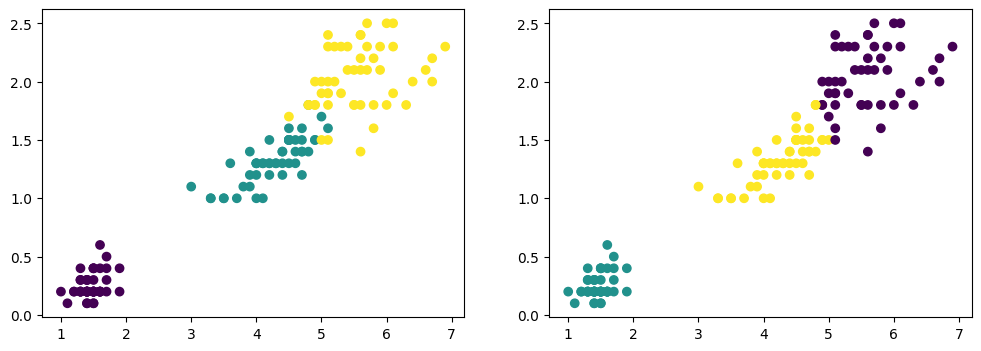

In [6]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
iris = load_iris(); X = iris.data[:, [2, 3]]; y = iris.target
K = 3 # <<< select the number of clusters
y_pred = KMeans(n_clusters=K, n_init=1, random_state=42).fit(X).predict(X)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(*X.T, c=y); axes[1].scatter(*X.T, c=y_pred);

# 6 Evaluation of clustering

**Rand Index:** $\;$ measure of similarity between two partitions (or labels) of a set $X$ of $N$ data samples, a reference partition, $\,R=\{R_1,\dotsc, R_C\}\,$ and a predicted partition, $\,P=\{P_1,\dotsc,P_K\}$
$$\operatorname{RI}=\frac{a+b}{a+b+c+d}$$
* $a$ is the number of pairs of $X$ that are in the **same** cluster of $R$ and in the **same** cluster of $P$
* $b$ is the number of pairs of $X$ that are in **different** clusters of $R$ and in **different** clusters of $P$
* $c$ is the number of pairs of $X$ that are in the **same** cluster of $R$ and in **different** clusters of $P$
* $d$ is the number of pairs of $X$ that are in **different** clusters of $R$ and in the **same** cluster of $P$
* Calculated from all $N(N-1)$ ordered pairs or, more easily, from all $N(N-1)/2$ unordered

**Interpretation:** $\;\operatorname{RI}\in[0,1]$
* $\operatorname{RI}=0\,$ if and only if $R$ and $P$ do not agree on any pair
* $\operatorname{RI}=1\,$ if and only if $R$ and $P$ match (except permutations of cluster labels)
* It is a symmetric measure, that is, it gets the same value if we exchange reference and prediction partitions
* Does not guarantee a value close to zero for a random prediction

**Example:** $\;N=4\,$ data samples with reference labels $\,R=(0, 0, 1, 1)\,$ and prediction $\,P=(2,2,0 ,1)$
$$\begin{align*}
\{i,j\}&&1&&2&&3&&4\\\hline
1&& &&a&&b&&b\\
2&& && &&b&&b\\
3&& && && &&c
\end{align*}\quad\Rightarrow\quad\operatorname{RI}=\frac{1+4}{6}=0.83$$

In [7]:
from sklearn import metrics
R = [0, 0, 1, 1]; P = [2, 2, 0, 3]; RI = metrics.rand_score(R, P)
print(f'RI({R},{P}) = {RI:.4f}')

RI([0, 0, 1, 1],[2, 2, 0, 3]) = 0.8333


**Adjusted Rand Index:** $\;\operatorname{ARI}\in[-1,1],\,$ discounts the expected Rand Index from a random prediction (see [description in Wikipedia](https://en.wikipedia.org/wiki/Rand_index#Adjusted_Rand_index))

In [8]:
ARI = metrics.adjusted_rand_score(R, P)
print(f'ARI({R},{P}) = {ARI:.4f}')

ARI([0, 0, 1, 1],[2, 2, 0, 3]) = 0.5714


**Example:** $\;$ evaluation of $K$-means applied to the Iris dataset

In [9]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn import metrics
iris = load_iris(); X = iris.data[:, [2, 3]]; y = iris.target
K = 3 # <<< tria nombre de clústers
y_pred = KMeans(n_clusters=K, n_init=1, random_state=42).fit(X).predict(X)
RI = metrics.rand_score(y, y_pred); ARI = metrics.adjusted_rand_score(y, y_pred)
print(f'RI = {RI:.4f}  ARI = {ARI:.4f}');

RI = 0.9495  ARI = 0.8857
